In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapely as shy
from shapely.ops import nearest_points
from shapely.geometry import Point, MultiPoint
import fiona
from fiona.crs import from_epsg
from scipy.spatial import cKDTree
import numpy as np
import osmnx as ox

pd.options.display.max_rows = 4
%matplotlib inline
import os
os.environ["PROJ_LIB"] = "C:\ProgramData\Anaconda3\Library\share" #window

In [2]:
#Filepaths
work = r"D:"
laptop = r"C:\Users\jerem"
origin = work

In [14]:
fp = r"\Box Sync\Policy Evaluation\working_data\analytical_panel_shapefile\analytical_panel_qt_shapefile_panel_thiessen_polygons.shp"
df1 = gpd.read_file(origin+fp)

In [5]:
df1.head(3)

,collision_,personsinj,pedestrian,cyclistinj,motoristin,bronx,brooklyn,manhattan,queens,statenisla,...,flag_prior,flag_schoo,flag_stree,quarter,year,intersecti,y,x,DUP_IDS,geometry
0,3,0,0,0,0,0,0,1,0,0,...,1,0,0,1,2013,1,199793.6093,986336.1490,1,"POLYGON ((986150.2933460365 199702.6472557705,..."
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,2013,2,202206.1619,982769.3310,2,"POLYGON ((982610.6377425257 202090.8501983829,..."
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,2013,3,201790.0942,982805.6184,3,"POLYGON ((982528.6632446027 201736.7410315565,..."


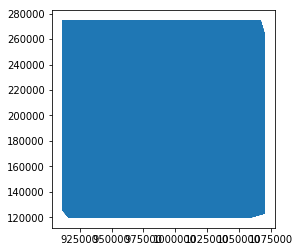

In [6]:
df1.plot()

In [7]:
df1.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [8]:
fp = r"\Box Sync\Policy Evaluation\input_data\nyc_boroughs_2263\nyc_boroughs_2263.shp"
df2 = gpd.read_file(origin+fp)

In [9]:
df2.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [10]:
# Reproeject LPIS shapefile to EPSG 2263: NAD83 / New York Long Island (ftUS)
df2 = df2.to_crs({'init': 'epsg:4326'})

In [11]:
df2.crs

{'init': 'epsg:4326'}

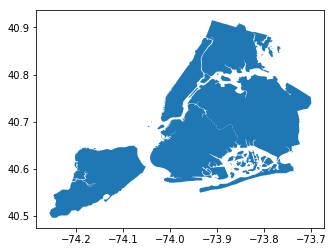

In [12]:
df2.plot()

In [16]:
df2.crs = df1.crs

In [17]:
# Intersection
intersection = gpd.overlay(df1, df2, how='intersection')

KeyError: "labels ['__idx1' '__idx2'] not contained in axis"

In [ ]:
intersection.plot()